In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import causalinference as ci
from causalinference import CausalModel
import time

In [8]:
start = time.time()
data_a = pd.read_csv('data/ss16pusa.csv')
data_b = pd.read_csv('data/ss16pusb.csv')
end = time.time()
print("{} seconds".format(end-start))

220.1479480266571 seconds


In [12]:
data = pd.concat([data_a, data_b])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3156487 entries, 0 to 1533270
Columns: 284 entries, RT to pwgtp80
dtypes: float64(83), int64(198), object(3)
memory usage: 6.7+ GB


In [16]:
data.head()

RT  SERIALNO  SPORDER  PUMA  ST   ADJINC  PWGTP  AGEP  CIT  CITWP   ...     \
0  P        64        1   700   1  1007588     98    84    1    NaN   ...      
1  P        64        2   700   1  1007588     89    84    1    NaN   ...      
2  P        80        1   900   1  1007588     95    78    1    NaN   ...      
3  P       107        1   302   1  1007588    160    46    1    NaN   ...      
4  P       107        2   302   1  1007588    154    52    1    NaN   ...      

   pwgtp71  pwgtp72  pwgtp73  pwgtp74  pwgtp75  pwgtp76  pwgtp77  pwgtp78  \
0       95       98       27       31      174       93      111       87   
1       97       91       30       27      141       93       98      100   
2      118       88      145       81      144       80       93       82   
3      152       50      200       45       45      313      183      258   
4      164       48      158       51       44      287      165      277   

   pwgtp79  pwgtp80  
0      168       21  
1      177       25  
2       24      210  
3      151      168  
4      163      160  

[5 rows x 284 columns]

In [28]:
def pr_treat(col):
    if col <= 56:
        return 0
    elif col == 72:
        return 1
    else:
        return np.nan

In [141]:
dc = pd.DataFrame()
dc['id'] = data.SERIALNO
dc['puma'] = data.PUMA
dc['age'] = data.AGEP
dc['sex'] = (data.SEX > 1).astype(int)
dc['hispanic'] = (data.HISP > 1).astype(int)
dc['edu'] = data.SCHL
dc['treat'] = data.POBP.apply(pr_treat)
dc['income'] = data.PINCP
dc['disab'] = (data.DIS == 1).astype(int)
dc['english'] = data.ENG.fillna(1)
dc['posinc'] = dc.income
dc.loc[(dc.posinc < 0), 'posinc'] = dc.loc[(dc.posinc < 0), 'posinc'] + 20001
dc.loc[dc.posinc == 0, 'posinc'] = 1
dc['loginc'] = np.log(dc.posinc)
dc['inc_raw'] = (data.OIP + data.PAP + data.RETP + data.SSIP + data.SSP + data.WAGP).astype(float)
dc['inc_raw'] = dc.inc_raw.replace(np.inf, np.nan).replace(0, np.nan)
dc['log_incraw'] = np.log(dc.inc_raw)

In [142]:
print(dc.info(verbose=True, null_counts=True))
dc.dropna(inplace=True)
print(dc.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3156487 entries, 0 to 1533270
Data columns (total 14 columns):
id            3156487 non-null int64
puma          3156487 non-null int64
age           3156487 non-null int64
sex           3156487 non-null int64
hispanic      3156487 non-null int64
edu           3060717 non-null float64
treat         2754706 non-null float64
income        2624319 non-null float64
disab         3156487 non-null int64
english       3156487 non-null float64
posinc        2624319 non-null float64
loginc        2624319 non-null float64
inc_raw       2192953 non-null float64
log_incraw    2192953 non-null float64
dtypes: float64(8), int64(6)
memory usage: 361.2 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893461 entries, 0 to 1533270
Data columns (total 14 columns):
id            1893461 non-null int64
puma          1893461 non-null int64
age           1893461 non-null int64
sex           1893461 non-null int64
hispanic      1893461 non-null int6

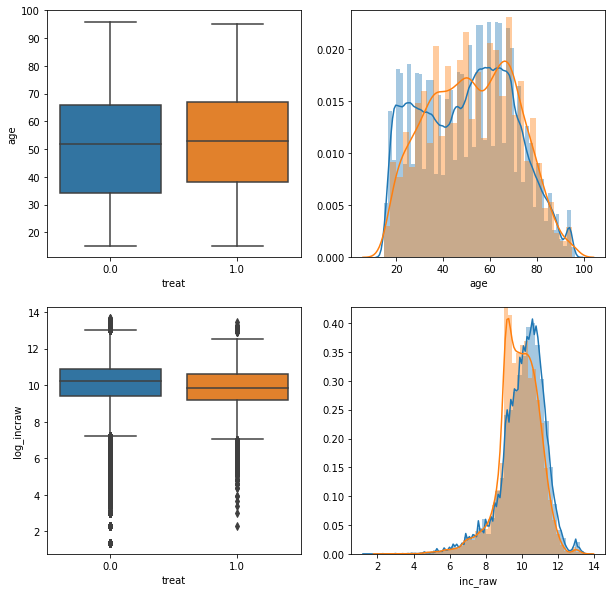

In [334]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.distplot(dc[dc.treat == 0].age, label='control', ax=axes[0,1])
sns.distplot(dc[dc.treat == 1].age, label='treat', ax=axes[0,1])
sns.boxplot(x="treat", y="age", data=dc, ax=axes[0,0])

# sns.distplot(np.log(abs(data.PINCP.dropna() + 1)), label='control', ax=axes[1,1])
sns.distplot(np.log(dc[dc.treat == 0].inc_raw), label='control', ax=axes[1,1])
sns.distplot(np.log(dc[dc.treat == 1].inc_raw), label='treat', ax=axes[1,1])
sns.boxplot(x="treat", y="log_incraw", data=dc, ax=axes[1,0])

# plt.title('Distributions of Age and Log-Income')

f.savefig('plots1.png')
# sns.barplot(x="edu", y="edu", data=dc[dc.treat==0], estimator=lambda x: len(edu) / len(dc[dc.treat==0]) * 100)

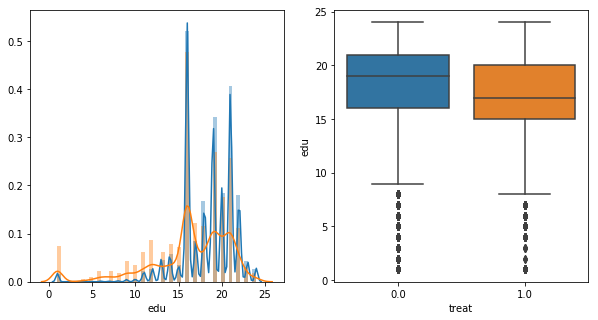

In [356]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))

# sns.countplot(x='treat', hue='sex', data=dc,  ax=axes[0])
# sns.countplot(x='sex', data=dc[dc.treat == 1],  ax=axes[1])
sns.distplot(dc[dc.treat == 0].edu, ax=axes[0])
sns.distplot(dc[dc.treat == 1].edu, ax=axes[0])
sns.boxplot(x="treat", y="edu", data=dc, ax=axes[1])
# plt.title('Distributions of Age and Log-Income')

f.savefig('plots2.png')

In [145]:
dc.groupby('treat').count()

id     puma      age      sex  hispanic      edu   income  \
treat                                                                   
0.0    1882428  1882428  1882428  1882428   1882428  1882428  1882428   
1.0      11033    11033    11033    11033     11033    11033    11033   

         disab  english   posinc   loginc  inc_raw  log_incraw  
treat                                                           
0.0    1882428  1882428  1882428  1882428  1882428     1882428  
1.0      11033    11033    11033    11033    11033       11033

# Causal Modeling

In [316]:
samp = pd.concat([dc[dc.treat == 0].sample(11033), dc[dc.treat == 1]])
Y = samp.inc_raw.as_matrix()
D = samp.treat.as_matrix()
X = samp[['age', 'sex', 'hispanic', 'edu', 'disab', 'english']].as_matrix()
causal = CausalModel(Y, D, X)

In [317]:
ss = causal.summary_stats
print(ss)


Summary Statistics

                     Controls (N_c=11033)       Treated (N_t=11033)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y    41899.365    53462.584    31065.515    40150.126   -10833.850

                     Controls (N_c=11033)       Treated (N_t=11033)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       50.385       19.454       52.519       18.431        0.113
             X1        0.505        0.500        0.530        0.499        0.051
             X2        0.072        0.259        0.970        0.171        4.090
             X3       18.247        3.203       16.331        4.804       -0.469
             X4        0.189        0.392        0.272        0.445        0.199
      

In [318]:
causal.est_via_ols()

In [319]:
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   5643.161   2102.858      2.684      0.007   1521.559   9764.763
           ATC  10701.793   3398.457      3.149      0.002   4040.818  17362.768
           ATT    584.529   2245.278      0.260      0.795  -3816.216   4985.274



In [320]:
causal.est_propensity_s()

In [321]:
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -7.382      0.538    -13.725      0.000     -8.436     -6.328
            X2      5.229      0.280     18.656      0.000      4.679      5.778
            X5      2.914      0.456      6.384      0.000      2.020      3.809
            X0      0.061      0.010      5.925      0.000      0.041      0.081
            X3     -0.072      0.036     -2.009      0.044     -0.143     -0.002
         X2*X0      0.028      0.004      7.004      0.000      0.020      0.036
         X0*X0     -0.001      0.000     -6.069      0.000     -0.001     -0.000
         X2*X5     -0.713      0.177     -4.041      0.000     -1.059     -0.367
         X3*X3      0.003      0.001      2.680      0.007      0.001      0.005
         X5*X5     -0.246      0.106     -2.310      0.021     -0.

In [322]:
causal.cutoff
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [323]:
causal.trim_s()

In [324]:
causal.cutoff

0.019426067160036364

In [325]:
print(causal.summary_stats)


Summary Statistics

                      Controls (N_c=9748)        Treated (N_t=7522)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y    45561.735    55499.133    36230.213    45126.210    -9331.521

                      Controls (N_c=9748)        Treated (N_t=7522)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       50.858       16.793       47.591       17.775       -0.189
             X1        0.497        0.500        0.516        0.500        0.038
             X2        0.079        0.270        0.958        0.200        3.706
             X3       18.569        3.124       17.461        3.983       -0.309
             X4        0.173        0.379        0.199        0.399        0.065
      

In [284]:
causal.blocks = 5

In [285]:
causal.stratify()

In [286]:
print(causal.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.004     0.006     10753        44     0.005     0.005  3830.238
         2     0.006     0.007     10734        62     0.007     0.007  7478.838
         3     0.007     0.008     10710        86     0.008     0.008  5247.374
         4     0.008     0.625      9007      1786     0.106     0.471-31831.321
         5     0.625     0.992      1768      9027     0.766     0.847-11202.716



In [326]:
causal.est_via_matching()

In [327]:
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   2900.585   2555.285      1.135      0.256  -2107.774   7908.944
           ATC   3875.431   3529.931      1.098      0.272  -3043.234  10794.095
           ATT   1637.252   3394.890      0.482      0.630  -5016.733   8291.237



In [328]:
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   2859.325   2556.979      1.118      0.263  -2152.353   7871.003
           ATC   3755.316   3536.992      1.062      0.288  -3177.189  10687.821
           ATT   1698.182   3389.375      0.501      0.616  -4944.994   8341.357



In [329]:
causal.est_via_matching(matches = 4, bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1681.029   1945.334      0.864      0.388  -2131.826   5493.885
           ATC   3213.652   2765.457      1.162      0.245  -2206.644   8633.949
           ATT   -305.145   2387.097     -0.128      0.898  -4983.855   4373.565



# Using Log-Income

In [309]:
samp = pd.concat([dc[dc.treat == 0].sample(11033), dc[dc.treat == 1]])
Y = samp.log_incraw.as_matrix()
D = samp.treat.as_matrix()
X = samp[['age', 'sex', 'hispanic', 'edu', 'disab', 'english']].as_matrix()
causal = CausalModel(Y, D, X)

In [310]:
ss = causal.summary_stats
print(ss)


Summary Statistics

                     Controls (N_c=11033)       Treated (N_t=11033)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       10.083        1.208        9.817        1.112       -0.266

                     Controls (N_c=11033)       Treated (N_t=11033)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       51.139       19.447       52.519       18.431        0.073
             X1        0.512        0.500        0.530        0.499        0.036
             X2        0.069        0.253        0.970        0.171        4.171
             X3       18.239        3.250       16.331        4.804       -0.465
             X4        0.193        0.394        0.272        0.445        0.189
      

In [311]:
causal.est_via_ols()
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.097      0.047      2.076      0.038      0.005      0.189
           ATC      0.172      0.061      2.839      0.005      0.053      0.291
           ATT      0.022      0.068      0.322      0.747     -0.111      0.155



In [312]:
causal.est_propensity_s()
print(causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -9.161      0.714    -12.826      0.000    -10.561     -7.761
            X2      5.585      0.297     18.797      0.000      5.003      6.167
            X5      5.316      0.608      8.740      0.000      4.124      6.508
            X0      0.045      0.010      4.305      0.000      0.024      0.065
            X3     -0.011      0.045     -0.235      0.814     -0.099      0.078
            X4      0.209      0.092      2.276      0.023      0.029      0.389
         X2*X0      0.026      0.004      6.630      0.000      0.019      0.034
         X0*X0     -0.000      0.000     -4.623      0.000     -0.001     -0.000
         X2*X5     -0.988      0.195     -5.055      0.000     -1.371     -0.605
         X5*X5     -0.530      0.103     -5.121      0.000     -0.

In [313]:
causal.trim_s()
print(causal.cutoff)
print(causal.summary_stats)

0.0185809458722

Summary Statistics

                     Controls (N_c=10301)        Treated (N_t=7467)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y       10.163        1.153        9.969        1.152       -0.194

                     Controls (N_c=10301)        Treated (N_t=7467)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       50.732       17.836       47.522       17.907       -0.180
             X1        0.507        0.500        0.517        0.500        0.021
             X2        0.071        0.256        0.957        0.203        3.833
             X3       18.487        3.139       17.592        3.893       -0.253
             X4        0.186        0.390        0.193        0.394    

In [314]:
causal.est_via_matching()
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.017      0.068     -0.254      0.799     -0.151      0.117
           ATC      0.012      0.101      0.124      0.902     -0.185      0.210
           ATT     -0.059      0.077     -0.757      0.449     -0.210      0.093

